# Introduction to accidents data project

## Motivation

In the realm of Data Science, a comprehensive project focused on car accidents unfolds, leveraging the power of data analysis and predictive modeling.

This endeavor aims to delve into the intricate patterns and underlying factors contributing to vehicular accidents.

This Data Science project seeks to extract valuable insightsand pave the way for effective accident prevention strategies. Through a meticulous exploration of extensive accident data, this undertaking aims to provide a deeper understanding of the complex dynamics at play, ultimately fostering safer roadways and improving the well-being of individuals and communities.

## Research question 📓

In this section, we aim to explore the significance and value of our project. By addressing this question, we can subsequently progress towards elucidating the appropriate methods and strategies to effectively reduce car accidents. Our objective is to leverage knowledge and insights gained from this research to implement proactive measures and promote safety on the roads.

> The following question is the lead question of our project: **Can you predict car accident?**

Another question that we searched answer for:
1. What are the primary causes of car accidents in a specific region?
2. How do weather conditions contribute to car accidents?
3. How does the time of day or day of the week influence the likelihood of car accidents?
4. Are there more accidents that occur during holidays?

## Data acquistion
All data is sourced from formal databases, which are based on real events.

### API's
> Gov API: https//data.gov.il/api/3/action/datastore_search

> ~~NHTSA API: https://www.nhtsa.gov/data/crash-data-systems~~

> ~~CBS API: https://www.cbs.gov.il/#1~~

### General websites
we extracted **3** ZIP file from the following website: 
> CBS website: https://www.cbs.gov.il/he/publications/Pages/2015/%D7%AA%D7%95%D7%A6%D7%A8%D7%99-Public-Use-Files-PUF-%D7%A0%D7%AA%D7%95%D7%A0%D7%99-%D7%A4%D7%A8%D7%98-%D7%91%D7%9C%D7%AA%D7%99-%D7%9E%D7%96%D7%95%D7%94%D7%99%D7%9D-%D7%9C%D7%9E%D7%97%D7%A7%D7%A8.aspx



In [99]:
import requests
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics
import os
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt





In [100]:
# Custom class
class DataRetriever:
    # Constructor
    def __init__(self, url):
        self.url = url
        self.df_data = pd.DataFrame()

    # Setters
    def retrieve_records(self, resource, selected_params=None, filters="limit=99999"):
        uri = f"{self.url}{resource}&{filters}"
        response = requests.get(uri)

        if response.status_code == 200:
            data = response.json()['result']['records']

            self.df_data = pd.concat([self.df_data, pd.DataFrame(data)], ignore_index=True)
            return 200

        return 500

    def extract_data_zip(self, zip_path, zip_name, csv_file):

        response = requests.get(zip_path)

        with open(zip_name, 'wb') as f:
            f.write(response.content)

        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extract(csv_file)

        data = pd.read_csv(csv_file)

        os.remove(csv_file)
        os.remove(zip_name)

        self.df_data = pd.concat([self.df_data, data], ignore_index=True)

    def rename_data(self, new_params):
        for old_name, new_name in new_params.items():
            if old_name in self.df_data.columns:
                if new_name not in self.df_data.columns:
                    self.df_data.rename(columns={old_name: new_name}, inplace=True)
                else:
                    self.df_data[new_name] = self.df_data[new_name].fillna(self.df_data[old_name])
                    del self.df_data[old_name]

    def set_col_data(self, col_name, col):
        self.df_data[col_name] = col

    def merge_data(self, df_data):
        self.df_data = pd.concat([self.df_data, df_data], ignore_index=True)

    def replace_data(self, new_data):
        self.df_data = new_data

    # Getters
    def get_data(self):
        return self.df_data

    def get_col_data(self, col_name):
        return self.df_data[col_name]



In [101]:


# Return's all data that extract from Gov as DataFrame
def get_gov_data():
   
    gov_url = "https://data.gov.il/api/3/action/datastore_search?resource_id="
    gov_data = DataRetriever(url=gov_url)
    # Gov variables for extract from .zip files
    gov_csv_files = {
        "2016.zip": "H20161332Accdatamekuzar.csv",
        "2017.zip": "H20171332AccdataMEKUZAR.csv",
        "2020.zip": "H20201331Data.csv"
    }
    gov_zip_file_prefix = "קבצים להורדה - תאונות מקוצר "
    gov_zip_path = "https://www.cbs.gov.il/he/publications/DocLib1/2015/PUF/%D7%AA%D7%97%D7%91%D7%95%D7%A8%D7%94/%D7" \
                   "%A7%D7%91%D7%A6%D7%99%D7%9D%20%D7%9C%D7%94%D7%95%D7%A8%D7%93%D7%94%20-%20%D7%AA%D7%90%D7%95%D7%A0" \
                   "%D7%95%D7%AA%20%D7%9E%D7%A7%D7%95%D7%A6%D7%A8%20"

    # General Gov variables
    gov_resources = {
        'year': ['ecf37201-e71a-4af5-99a5-062fdf07a38d', 'f372a398-e2c1-408c-8333-e758cf2124c5'],
        'area': ['b17b1634-c001-4d37-96c6-a661b2ecd98c'],
        'zip': ['2016.zip', '2017.zip', '2020.zip']
    }

    gov_new_params_name = {
        'MEZEG_AVIR': 'weather', # 1
        'SEMEL_YISHUV': 'city', # 1
        'SHNAT_TEUNA': "year", # 1
        'HODESH_TEUNA': 'month', # 1
        'SUG_YOM': 'day_type', # 1
        'YOM_LAYLA': 'day_time', # 1
        'YOM_BASHAVUA': 'day', # 1
        'HUMRAT_TEUNA': 'accident_severity', # 1
        'SUG_TEUNA': 'accident_type' # 0
    }
    # END OF GOV VARIABLES #

    # Request all data from Gov API & store in 'gov_data' DF
    for key in gov_resources.keys():

        print(f"fetching data from {key} resource")

        if key == 'area':
            for gov_resource in gov_resources[key]:
                temp = DataRetriever(url=gov_url)
                temp.retrieve_records(gov_resource)
                temp.rename_data(new_params=gov_new_params_name)
                
                gov_data.merge_data(df_data=temp.get_data())
                del temp

        elif key == 'year':
            for gov_resource in gov_resources[key]:
                gov_data.retrieve_records(gov_resource)

        elif key == 'zip':
            for gov_zip in gov_resources[key]:
                gov_data.extract_data_zip(zip_path=f"{gov_zip_path}{gov_zip}",
                                          zip_name=f"{gov_zip_file_prefix}{gov_zip}",
                                          csv_file=gov_csv_files[gov_zip])

    gov_data.rename_data(new_params=gov_new_params_name)
    # gov_data.replace_data(new_data=(convert_to_city_name('city', gov_data.get_data())))
    return gov_data.get_data()



gov_df = get_gov_data()


fetching data from year resource
fetching data from area resource
fetching data from zip resource


In [57]:
gov_df.head()

,_id,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,city,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,...,MOTORCYCLE,TRUCK,BICYCLE,PRIVATE,VEHICLE,ACC_INDEX,AreaSQKM,YEARMONTH,Shape_Length,Shape_Area
0,1.0,2018000004,1,1,1,841,104,105,None,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2018000018,1,1,1,4000,896,825,None,10210522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,2018000030,1,1,1,7100,1035,496,None,10800341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,2018000037,1,1,4,0,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,2018000049,1,1,3,0,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
gov_df.shape

(63831, 73)

## Cleaning Data

In [104]:
def clean_data(data, selected_params):
    data = data[selected_params]
    data = data.dropna(subset=['accident_severity'])
    print("Success! data has been cleaned")
    return data


In [105]:
gov_resources_params =  ["weather", "city", "year", "month", "day_type", "day_time",
                         "day", "accident_severity", "accident_type"]
gov_df = clean_data(gov_df, gov_resources_params)

Success! data has been cleaned


In [106]:
gov_df.head()


,weather,city,year,month,day_type,day_time,day,accident_severity,accident_type
0,1,841,2018,9,4,5,1,3,2
1,1,4000,2018,6,4,1,1,3,2
2,1,7100,2018,6,4,5,1,2,8
3,1,0,2018,7,4,1,7,3,8
4,1,0,2018,1,4,5,5,3,2


In [63]:
print(gov_df.shape)

(62657, 9)


# EDA (Visualization)

In [70]:
# PREREQUISITES EDA functions
def convert_to_city_name(row_name, df):
    url = "https://data.gov.il/api/3/action/datastore_search?" \
          "resource_id=5c78e9fa-c2e2-4771-93ff-7f400a12f7ba" \
          "&limit=99999"
    response = requests.get(url)

    if response.status_code == 200:
        # Create dict with requested values (City code, city name)
        records = response.json()['result']['records']
        gov_cities_dict = {rec['סמל_ישוב'].strip(): rec['שם_ישוב_לועזי'] for rec in records}

        # Custom from knowledge
        gov_cities_dict.update({'0': 'INTER CITY'})

        df[row_name] = df[row_name].replace(gov_cities_dict)

    return df


In [78]:
# EDA functions
# Display top value for given column in DF
def display_top_values(col, amount, drop_values=None):

    if drop_values:
        col = col[col != drop_values]

    top_values = col.value_counts().head(amount).sort_values(ascending=False)

    plt.figure(figsize=(16, 5))
    plt.xlabel(top_values.name)
    plt.ylabel('Count')
    plt.title(f'Top {amount} Values in {top_values.name} column')

    sns.barplot(x=top_values.index, y=top_values.values, order=top_values.index)
    plt.show()


def display_cut_line(col):
    col = col.value_counts()
    plt.figure(figsize=(10, 6))
    plt.xlabel(col.name)
    plt.ylabel('Count')
    sns.lineplot(x=col.index, y=col.values)
    plt.show()


def display_multiple_lines(df, params):
    # Get the column names from params
    y_col = params[0]
    x_col = params[1]

    # Create a line plot
    sns.set(style="darkgrid")
    plt.figure(figsize=(10, 6))

    # Plot multiple lines based on unique values in x_col
    for value in df[x_col].unique():
        filtered_df = df[df[x_col] == value]
        counts = filtered_df[y_col].value_counts().sort_index()
        plt.plot(counts.index, counts.values, label=f"{x_col}={value}")

    # Set the labels and title
    plt.xlabel(y_col)
    plt.ylabel("Count")
    plt.title(f"Line Plot of {y_col} by {x_col}")
    plt.legend()

    # Display the line plot
    plt.show()


def display_heatmap(df):
    # Create a pivot table to aggregate the data
    heatmap_table = df.pivot_table(index=df.columns[0], columns=df.columns[1], aggfunc=len, fill_value=0)

    sns.heatmap(heatmap_table, annot=True, cmap='YlGnBu', fmt='d', linewidth=.5)
    plt.title(f'{df.columns[0]} by {df.columns[1]}')
    plt.ylabel(df.columns[1])
    plt.xlabel(df.columns[0])
    plt.show()


def display_scatter(df, params):
    sns.scatterplot(data=df, x=df[params[0]], y=df[params[1]], hue=df[params[2]])
    plt.legend(loc='upper center')
    plt.show()

In [86]:
eda_df = convert_to_city_name('city', gov_df)

# Mapping numeric values to readable values
dict_weather = {"1": 'Sunny', "2": 'Rainy', "3": 'Extra hot', "4": 'Foggy', "5": 'Other', "9": 'Unknown'}
dict_day_time = {"1": 'Day', "5": 'Night'}
dict_accident_type = {
    "1": "Hit with walker",
    "10": "Rollover",
    "11": "Slip",
    "14": "Burn",
    "19": "Hit with animal",
    "2": "Accident with a vehicle",
    "20": "Injury from a vehicle load",
    "3": "Accident with a vehicle",
    "4": "Accident with a vehicle",
    "5": "Accident with a vehicle",
    "6": "Accident with a vehicle",
    "7": "Accident with a vehicle",
    "8": "Hit with object",
    "9": "Went down from the road",
    "12": "Accident with a vehicle",
    "13": "Accident with a vehicle",
    "15": "Accident with a vehicle",
    "16": "Accident with a vehicle",
    "17": "Accident with a vehicle",
    "18": "Accident with a vehicle"
}
eda_df = eda_df.astype(str)
eda_df['weather'] = eda_df['weather'].replace(dict_weather)
eda_df['day_time'] = eda_df['day_time'].replace(dict_day_time)
eda_df['accident_type'] = eda_df['accident_type'].replace(dict_accident_type)

In [87]:
eda_df.head()

,weather,city,year,month,day_type,day_time,day,accident_severity,accident_type
0,Sunny,ELISHAMA,2018,9,4,Night,1,3,Accident with a vehicle
1,Sunny,HAIFA,2018,6,4,Day,1,3,Accident with a vehicle
2,Sunny,ASHQELON,2018,6,4,Night,1,2,Hit with object
3,Sunny,INTER CITY,2018,7,4,Day,7,3,Hit with object
4,Sunny,INTER CITY,2018,1,4,Night,5,3,Accident with a vehicle


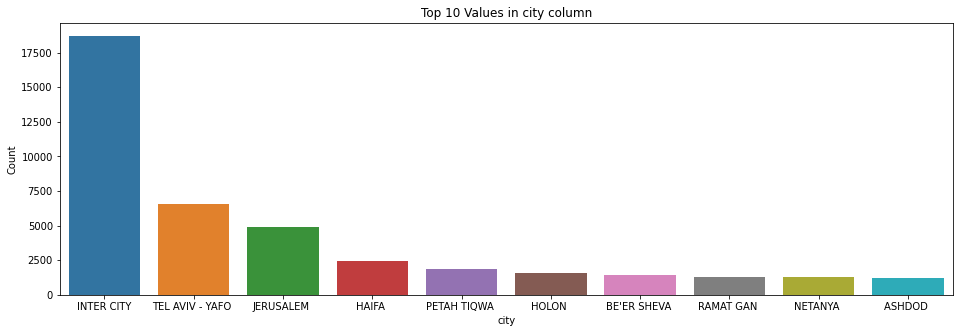

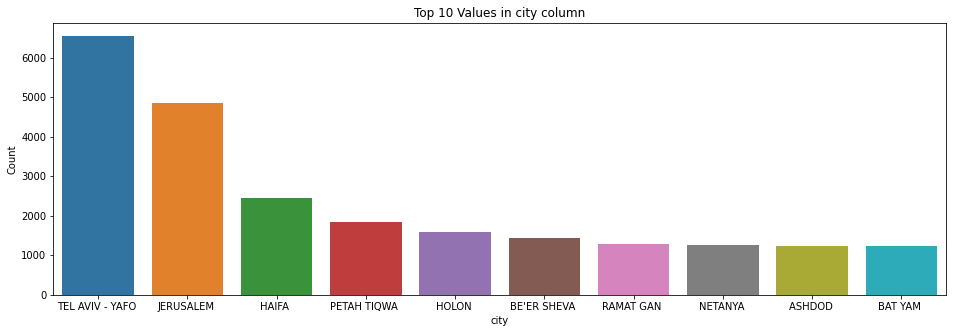

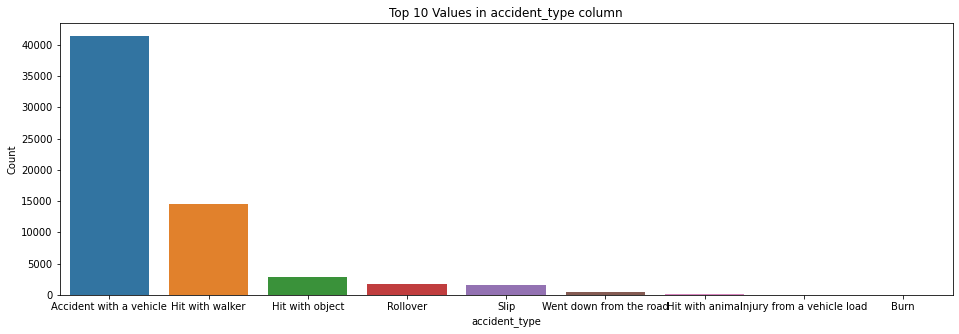

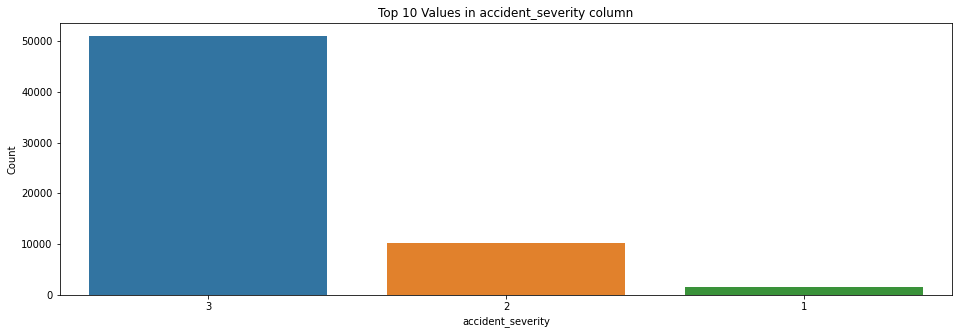

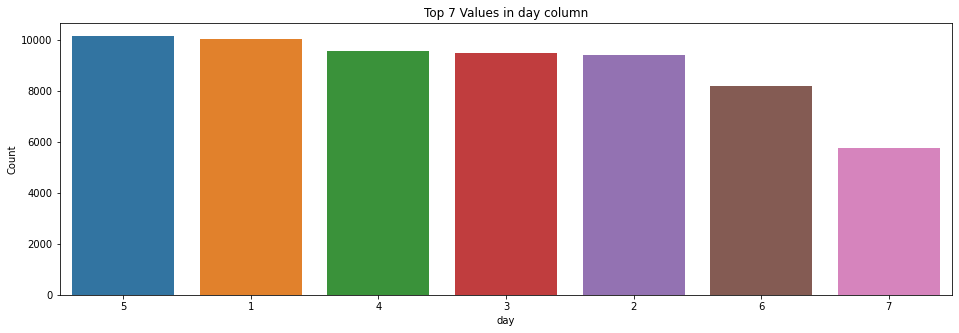

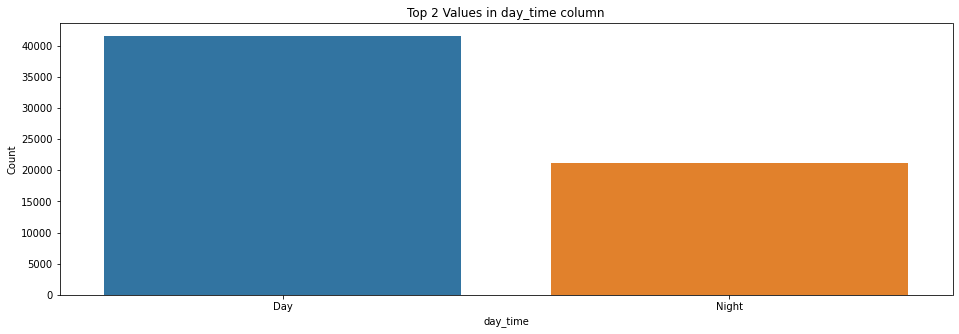

In [90]:
# Display top values of following columns
display_top_values(eda_df['city'], 10)
display_top_values(eda_df['city'], 10, 'INTER CITY')
display_top_values(eda_df['accident_type'],10)
display_top_values(eda_df['accident_severity'],10)
display_top_values(eda_df['day'],7)

display_top_values(eda_df['day_time'], 2)

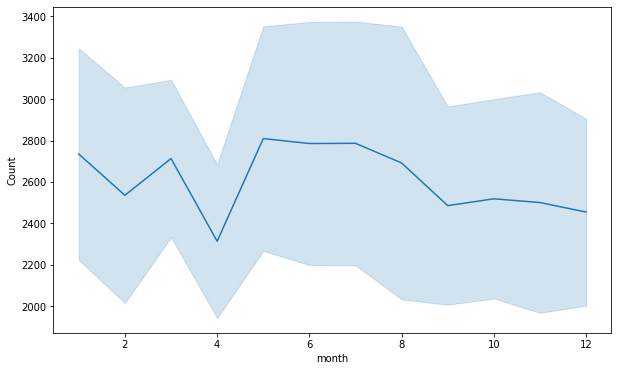

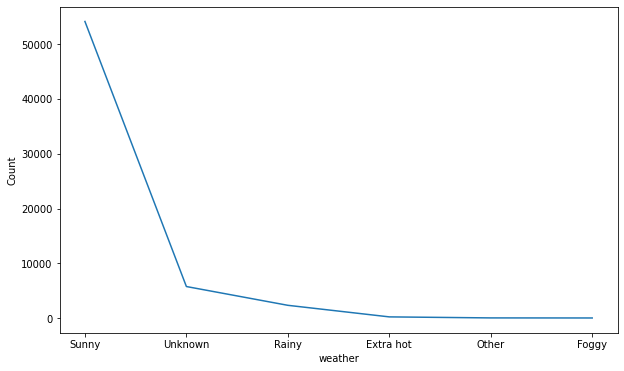

In [89]:
# Display accidents mapping by months
display_cut_line(gov_df['month'])   
display_cut_line(gov_df['weather'])


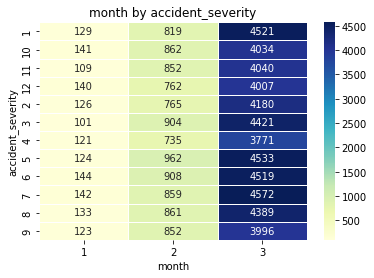

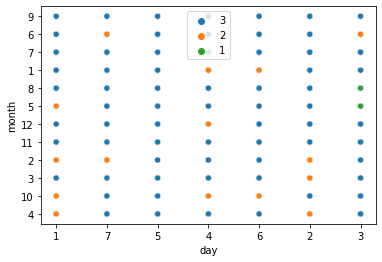

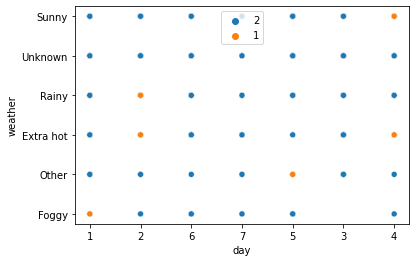

In [94]:
# Display heatmap
display_heatmap(eda_df[['month', 'accident_severity']])

# Display scatter
display_scatter(eda_df, ['day', 'month', 'accident_severity'])

# Display scatter after mapping
display_scatter(eda_df.drop(eda_df[eda_df['accident_severity'] == "3"].index),
                ['day', 'weather', 'accident_severity'])

# Machine learning - Logistic regression

In [125]:
def apply_LogisticRegression(gov_data,x_list, y_list):
    gov_data.fillna(0)
    logisticreg = LogisticRegression(max_iter=65000)

    X = gov_data[x_list]
    y = gov_data['accident_severity']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
    logisticreg.fit(x_train, y_train)
    y_pred = logisticreg.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy ,y_test, y_pred


# build confusion matrix on the resukts from the LogisticRegression
def build_confusion_matrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)
    return cm_df

def convert_to_numerical(gov_data):
    mapping = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6 ,'7': 7 ,'8': 8 ,'9': 9 ,'0': 0 ,'2018': 2018 ,'2019': 2019 }
    gov_data = gov_data.replace(mapping)
    return gov_data


In [129]:
x_list_lr = ['year', 'month', 'weather', 'day_type', 'day_time', 'day']
y_list_lr = ['accident_severity']
gov_df = gov_df.dropna(subset=['accident_severity'])
gov_df = gov_df.astype(int)
accuracy, y_test, y_pred = apply_LogisticRegression(gov_df, x_list_lr, y_list_lr)
cm_df = build_confusion_matrix(y_test, y_pred)
print("Confusion matrix of the logistic regression:")
print(cm_df)
print("\n")
print(f"accuracy of logistic regression: {accuracy}")

Confusion matrix of the logistic regression:
   0  1      2
0  0  0    297
1  0  0   2015
2  0  0  10220


accuracy of logistic regression: 0.8155122885413342
